In [3]:
import pandas as pd

# Load the dataset
file_path = "Petrol CSV w Date.csv"
data = pd.read_csv(file_path)

# Check the column names and the first few rows
print("Columns in the dataset:", data.columns)
print(data.head())


Columns in the dataset: Index(['date', 'consumption'], dtype='object')
   date  consumption
0  1980     542254.0
1  1981     589017.0
2  1982     644907.0
3  1983     690214.0
4  1984     754725.0


In [4]:
data = data.rename(columns={"Year": "ds", "Consumption": "y"})

In [7]:
data.head(5)

,date,consumption
0,1980,542254.0
1,1981,589017.0
2,1982,644907.0
3,1983,690214.0
4,1984,754725.0


In [8]:
# Rename columns to match Prophet's requirements
data = data.rename(columns={"date": "ds", "consumption": "y"})

# Convert 'ds' to datetime format
data["ds"] = pd.to_datetime(data["ds"], format='%Y')

# Add time-based features
data["day_of_week"] = data["ds"].dt.dayofweek
data["day_of_year"] = data["ds"].dt.dayofyear
data["month"] = data["ds"].dt.month
data["quarter"] = data["ds"].dt.quarter

# Display first few rows to confirm changes
print(data.head())


          ds         y  day_of_week  day_of_year  month  quarter
0 1980-01-01  542254.0            1            1      1        1
1 1981-01-01  589017.0            3            1      1        1
2 1982-01-01  644907.0            4            1      1        1
3 1983-01-01  690214.0            5            1      1        1
4 1984-01-01  754725.0            6            1      1        1


In [9]:
from prophet import Prophet


c:\Users\MoaviaHassan\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [ ]:
# Initialize the Prophet model
model = Prophet()

# Fit the model on the dataset
model.fit(data[["ds", "y"]])

# Display the training progress
print("Model trained successfully.")


02:33:37 - cmdstanpy - INFO - Chain [1] start processing
02:33:39 - cmdstanpy - INFO - Chain [1] done processing


Model trained successfully.


In [11]:
# Create a dataframe for future dates (next 10 years)
future = model.make_future_dataframe(periods=10, freq="Y")

# Forecast future values
forecast = model.predict(future)

# Display the forecasted values
print(forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(10))


           ds          yhat    yhat_lower    yhat_upper
44 2023-12-31  5.929738e+06  4.029743e+06  7.857037e+06
45 2024-12-31  6.232612e+06  4.391023e+06  8.143764e+06
46 2025-12-31  6.348806e+06  4.342932e+06  8.298688e+06
47 2026-12-31  6.464754e+06  4.676419e+06  8.289742e+06
48 2027-12-31  6.580516e+06  4.725872e+06  8.416699e+06
49 2028-12-31  6.883390e+06  4.904312e+06  8.809750e+06
50 2029-12-31  6.999584e+06  5.066573e+06  8.913130e+06
51 2030-12-31  7.115532e+06  5.189035e+06  9.043958e+06
52 2031-12-31  7.231293e+06  5.236762e+06  9.145375e+06
53 2032-12-31  7.534168e+06  5.567874e+06  9.367250e+06


c:\Users\MoaviaHassan\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


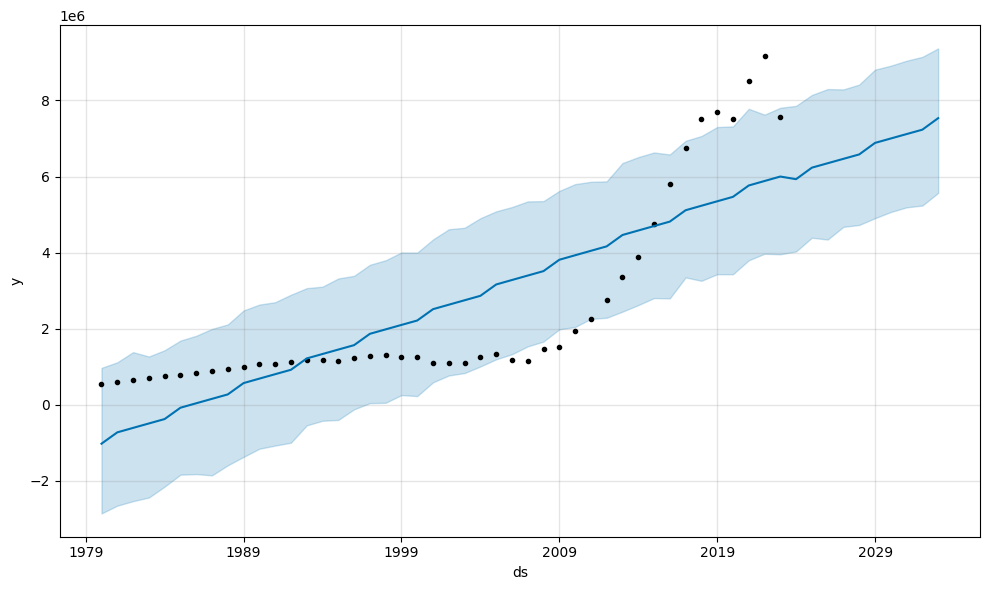

In [12]:
# Plot the forecast
fig = model.plot(forecast)


In [13]:
from sklearn.metrics import mean_absolute_error, r2_score

# Merge the actual and forecasted values for historical data
merged = data.merge(forecast, on="ds", how="left")

# Calculate errors
mae = mean_absolute_error(merged["y"], merged["yhat"])
mape = (abs(merged["y"] - merged["yhat"]) / merged["y"]).mean() * 100
r2 = r2_score(merged["y"], merged["yhat"])

# Print evaluation metrics
print(f"MAE: {mae}")
print(f"MAPE: {mape}%")
print(f"R²: {r2}")


MAE: 1256455.6140787425
MAPE: 83.41176797657253%
R²: 0.662529167812416


In [14]:
# Add seasonality to the Prophet model
model = Prophet(yearly_seasonality=True)  # Enable yearly seasonality

# Fit the model again
model.fit(data[["ds", "y"]])


02:37:27 - cmdstanpy - INFO - Chain [1] start processing
02:37:29 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
from prophet.diagnostics import cross_validation, performance_metrics
from prophet import Prophet

# Grid of parameters to search
param_grid = {
    "changepoint_prior_scale": [0.01, 0.1, 0.5, 1.0],
    "seasonality_prior_scale": [0.1, 1.0, 10.0],
}

# Store the results
best_params = None
best_mae = float("inf")

# Iterate over all combinations
for changepoint_prior in param_grid["changepoint_prior_scale"]:
    for seasonality_prior in param_grid["seasonality_prior_scale"]:
        # Initialize the model
        model = Prophet(
            changepoint_prior_scale=changepoint_prior,
            seasonality_prior_scale=seasonality_prior,
            yearly_seasonality=True
        )

        # Fit the model
        model.fit(data[["ds", "y"]])

        # Cross-validation to evaluate performance
        df_cv = cross_validation(
            model,
            horizon="3650 days",  # 10 years
            period="1825 days",  # 5 years
            initial="7300 days"  # 20 years
        )
        df_p = performance_metrics(df_cv)

        # Check if this combination is better
        if df_p["mae"].mean() < best_mae:
            best_mae = df_p["mae"].mean()
            best_params = {
                "changepoint_prior_scale": changepoint_prior,
                "seasonality_prior_scale": seasonality_prior,
            }

# Print the best parameters
print(f"Best Parameters: {best_params}")
print(f"Best MAE: {best_mae}")


02:38:34 - cmdstanpy - INFO - Chain [1] start processing
02:38:35 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]02:38:35 - cmdstanpy - INFO - Chain [1] start processing
02:38:35 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:01,  1.26it/s]02:38:36 - cmdstanpy - INFO - Chain [1] start processing
02:38:37 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:01<00:00,  1.04it/s]02:38:37 - cmdstanpy - INFO - Chain [1] start processing
02:38:38 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:02<00:00,  1.04it/s]
02:38:38 - cmdstanpy - INFO - Chain [1] start processing
02:38:39 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]02:38:39 - cmdstanpy - INFO - Chain [1] start processing
02:38:39 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:01,  1.04it/s]02:38:40 - cmdstanpy - INFO - Chain [1] start processing
02:38:40 -

Best Parameters: {'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 0.1}
Best MAE: 1984867.90911215


02:40:38 - cmdstanpy - INFO - Chain [1] start processing
02:40:39 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\MoaviaHassan\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


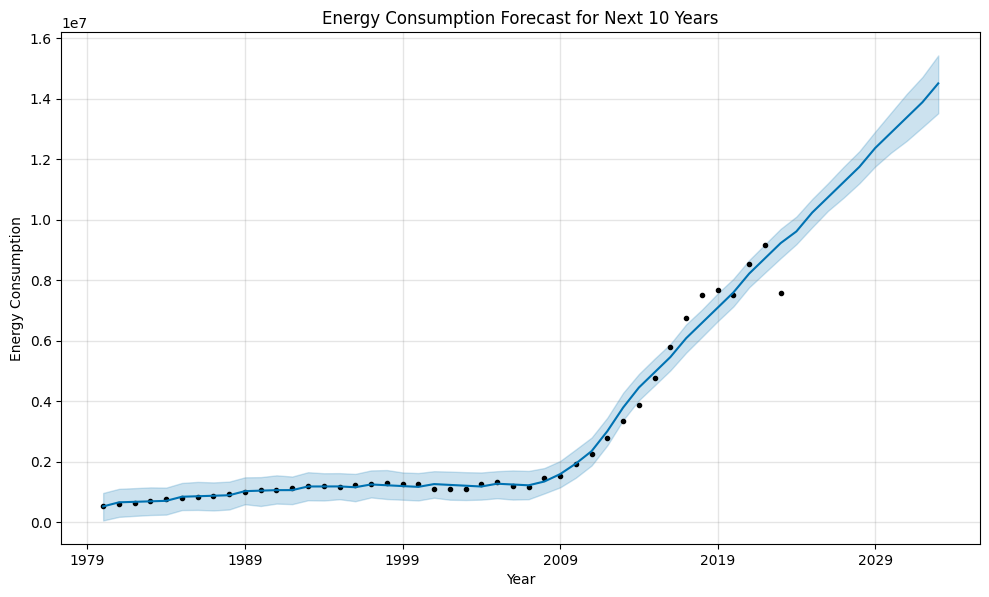

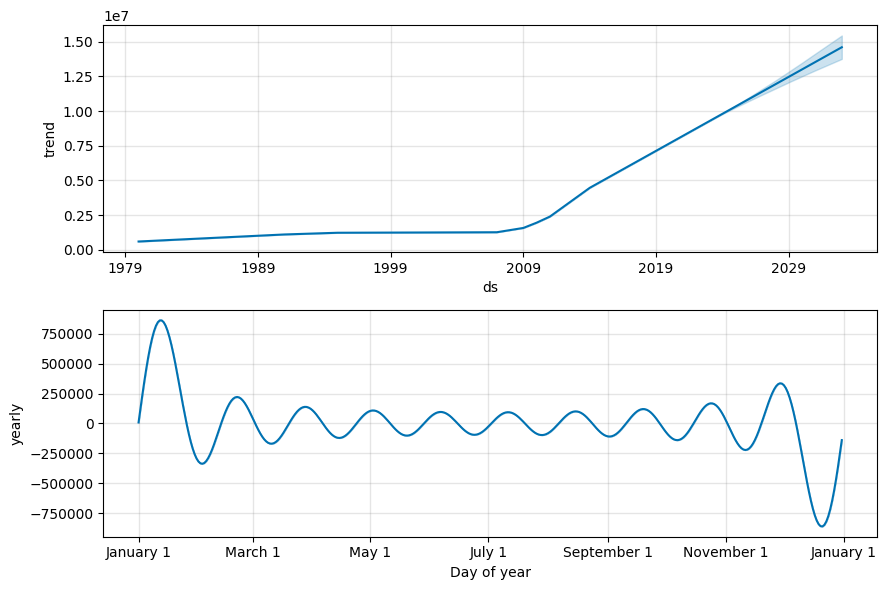

In [17]:
from prophet import Prophet
import matplotlib.pyplot as plt

# Best parameters from grid search
best_params = {
    "changepoint_prior_scale": 1.0,  # Update with the best value from grid search
    "seasonality_prior_scale": 0.1  # Update with the best value from grid search
}

# Train the final model
final_model = Prophet(
    changepoint_prior_scale=best_params["changepoint_prior_scale"],
    seasonality_prior_scale=best_params["seasonality_prior_scale"],
    yearly_seasonality=True
)

# Fit the model
final_model.fit(data[["ds", "y"]])

# Create a future dataframe for the next 10 years
future = final_model.make_future_dataframe(periods=10, freq="Y")

# Forecast future values
forecast = final_model.predict(future)

# Plot the forecast
fig = final_model.plot(forecast)
plt.title("Energy Consumption Forecast for Next 10 Years")
plt.xlabel("Year")
plt.ylabel("Energy Consumption")
plt.show()

# Plot components (trend, yearly seasonality, etc.)
fig2 = final_model.plot_components(forecast)
plt.show()


In [18]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

# Extract predictions for the historical period
forecast_history = forecast[forecast["ds"] <= data["ds"].max()]

# Compute evaluation metrics
mae = mean_absolute_error(data["y"], forecast_history["yhat"])
mape = mean_absolute_percentage_error(data["y"], forecast_history["yhat"]) * 100
r2 = r2_score(data["y"], forecast_history["yhat"])

print(f"Final Model MAE: {mae}")
print(f"Final Model MAPE: {mape:.2f}%")
print(f"Final Model R²: {r2}")


Final Model MAE: 185694.0664218701
Final Model MAPE: 6.02%
Final Model R²: 0.9804142996762213


In [19]:
# Extract only future forecasts
future_forecast = forecast[forecast["ds"] > data["ds"].max()]

# Display future predictions
print(future_forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]])


           ds          yhat    yhat_lower    yhat_upper
44 2023-12-31  9.607348e+06  9.185355e+06  1.009782e+07
45 2024-12-31  1.022971e+07  9.744697e+06  1.067906e+07
46 2025-12-31  1.073377e+07  1.028430e+07  1.119845e+07
47 2026-12-31  1.123800e+07  1.072338e+07  1.174480e+07
48 2027-12-31  1.174244e+07  1.119910e+07  1.226028e+07
49 2028-12-31  1.236480e+07  1.175189e+07  1.290770e+07
50 2029-12-31  1.286886e+07  1.220719e+07  1.352973e+07
51 2030-12-31  1.337309e+07  1.259895e+07  1.415033e+07
52 2031-12-31  1.387753e+07  1.305141e+07  1.471386e+07
53 2032-12-31  1.449989e+07  1.351236e+07  1.542385e+07


In [20]:
# Extract future forecast values into an array
future_forecast = forecast[forecast["ds"] > data["ds"].max()]
forecast_array = future_forecast["yhat"].values

# Display forecast values
print("Forecasted Energy Consumption (Next 10 Years):")
print(forecast_array)


Forecasted Energy Consumption (Next 10 Years):
[ 9607348.14396298 10229706.43905299 10733768.14873723 11238000.14068446
 11742437.80984764 12364796.10493746 12868857.81462147 13373089.80656903
 13877527.47573176 14499885.77082166]


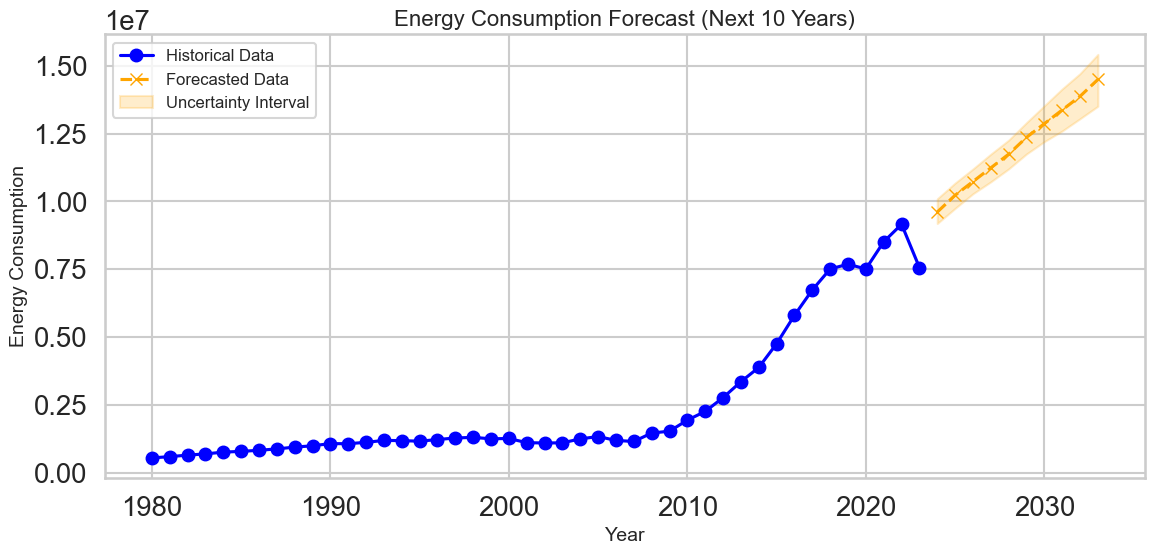

In [21]:
import seaborn as sns
sns.set(style="whitegrid", context="talk", font_scale=1.2)

# Plot the historical data and future forecast
plt.figure(figsize=(12, 6))
plt.plot(data["ds"], data["y"], label="Historical Data", color="blue", marker="o")
plt.plot(future_forecast["ds"], future_forecast["yhat"], label="Forecasted Data", color="orange", linestyle="--", marker="x")
plt.fill_between(
    future_forecast["ds"],
    future_forecast["yhat_lower"],
    future_forecast["yhat_upper"],
    color="orange",
    alpha=0.2,
    label="Uncertainty Interval"
)

# Customize the graph
plt.title("Energy Consumption Forecast (Next 10 Years)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Energy Consumption", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.tight_layout()
plt.savefig("forecast_line_graph.png", dpi=300)  # Save as PNG for publication
plt.show()


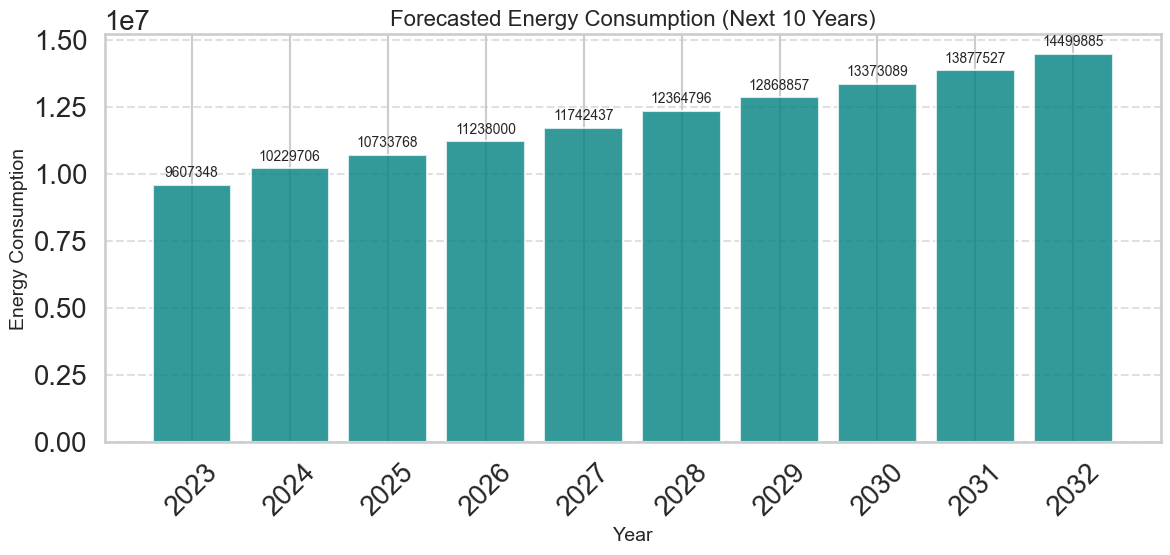

In [23]:
# Bar chart for forecasted values
plt.figure(figsize=(12, 6))
plt.bar(future_forecast["ds"].dt.year, forecast_array, color="teal", alpha=0.8)

# Customize the graph
plt.title("Forecasted Energy Consumption (Next 10 Years)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Energy Consumption", fontsize=14)
plt.xticks(future_forecast["ds"].dt.year, rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Add value annotations on the bars
for index, value in enumerate(forecast_array):
    plt.text(
        x=future_forecast["ds"].dt.year.iloc[index],
        y=value + 0.02 * max(forecast_array),
        s=f"{int(value)}",
        ha="center",
        fontsize=10
    )

plt.tight_layout()
plt.savefig("forecast_bar_chart.png", dpi=300)  # Save as PNG for publication
plt.show()


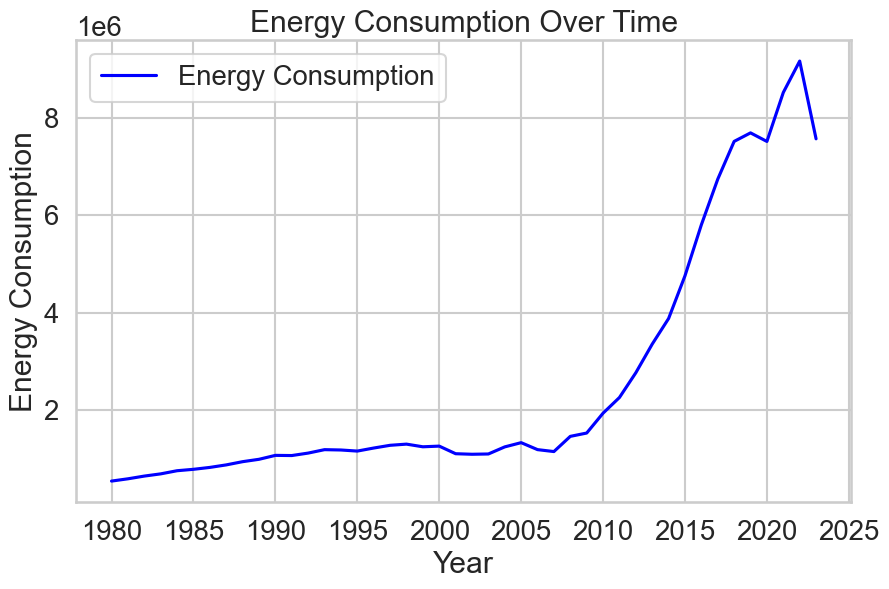

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(data["ds"], data["y"], label="Energy Consumption", color="blue")
plt.title("Energy Consumption Over Time")
plt.xlabel("Year")
plt.ylabel("Energy Consumption")
plt.grid(True)
plt.legend()
plt.show()


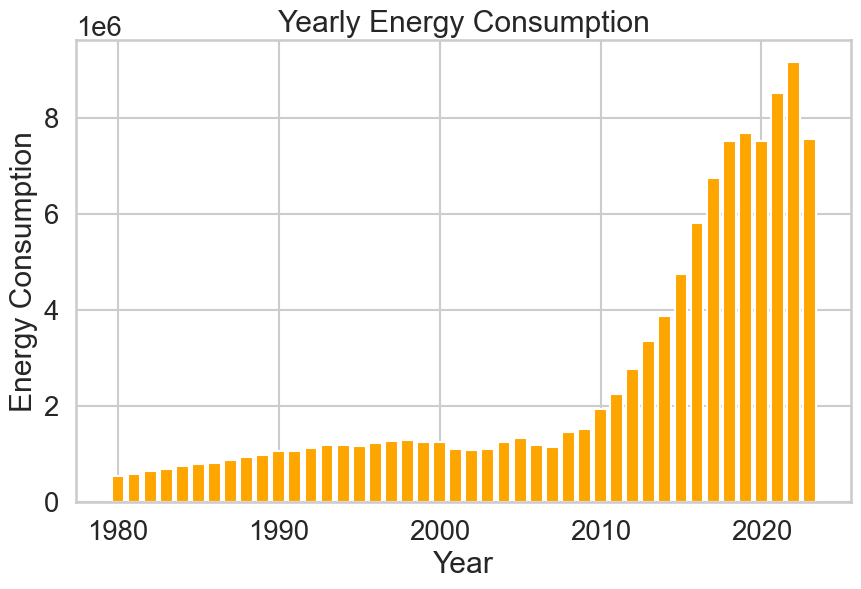

In [35]:
plt.figure(figsize=(10, 6))
plt.bar(data["ds"].dt.year, data["y"], color="orange")
plt.title("Yearly Energy Consumption")
plt.xlabel("Year")
plt.ylabel("Energy Consumption")
plt.show()


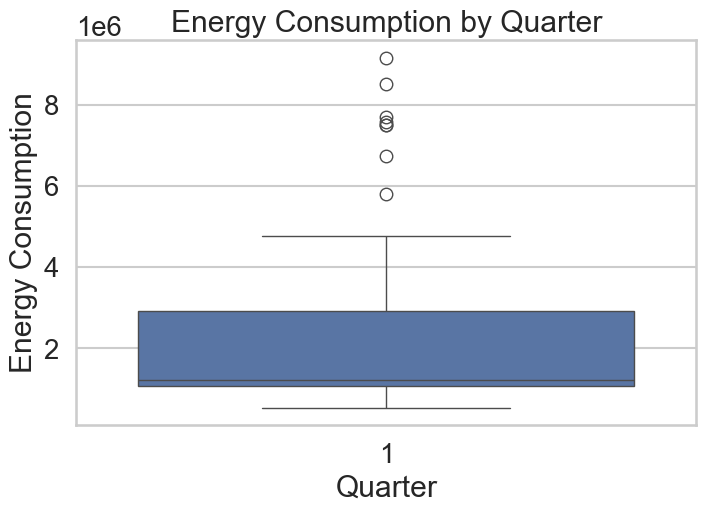

In [36]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.boxplot(x="quarter", y="y", data=data)
plt.title("Energy Consumption by Quarter")
plt.xlabel("Quarter")
plt.ylabel("Energy Consumption")
plt.show()


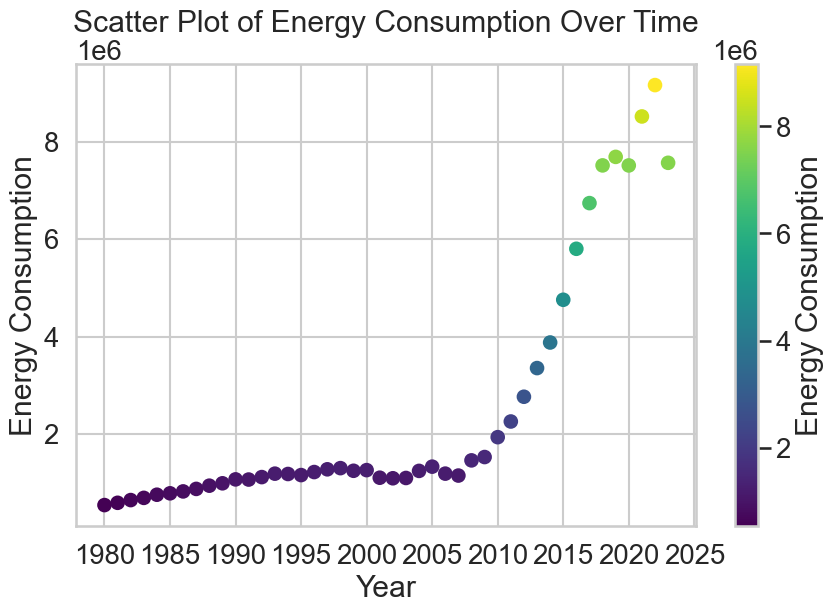

In [37]:
plt.figure(figsize=(10, 6))
plt.scatter(data["ds"], data["y"], c=data["y"], cmap="viridis")
plt.title("Scatter Plot of Energy Consumption Over Time")
plt.xlabel("Year")
plt.ylabel("Energy Consumption")
plt.colorbar(label="Energy Consumption")
plt.show()


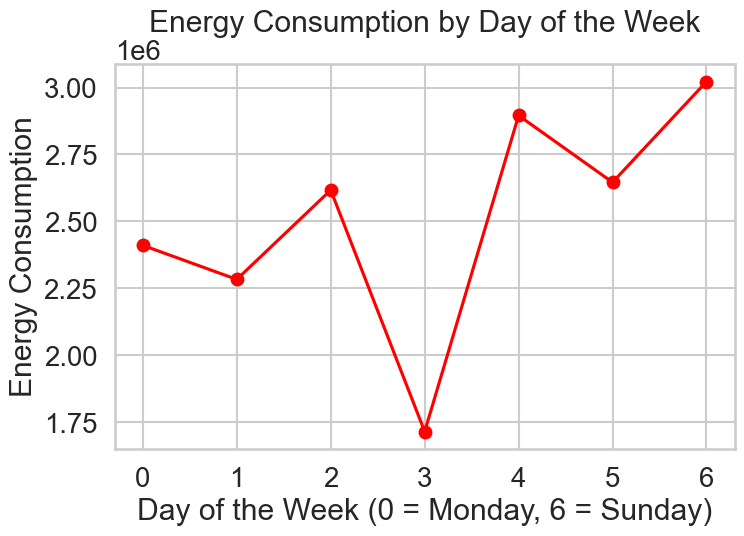

In [40]:
day_of_week_data = data.groupby("day_of_week")["y"].mean().reset_index()

plt.figure(figsize=(8, 5))
plt.plot(day_of_week_data["day_of_week"], day_of_week_data["y"], marker="o", linestyle="-", color="red")
plt.title("Energy Consumption by Day of the Week")
plt.xlabel("Day of the Week (0 = Monday, 6 = Sunday)")
plt.ylabel("Energy Consumption")
plt.grid(True)
plt.show()
